In [1]:
#分析演示程序,这是在测试集群上的测试程序，目前只有10M到20M的数据量，会根据分析结果，建议增加数据量
import pandas as pd
dataF=pd.read_csv('/root/pick.csv')

In [2]:
picDF=pd.read_csv('/root/pickHis.csv')

In [3]:
anjiDF=pd.concat([dataF,picDF],axis=0)
anjiDF.shape

(43473, 32)

In [4]:
#首先了解数据的结构和特点
anjiDF.info()#查看每一列的数据类型data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43473 entries, 0 to 13892
Data columns (total 32 columns):
PICK_TASK            43473 non-null int64
PICK_TYPE            43473 non-null int64
PICK_WAREHOUSE       43473 non-null object
PICK_PLANT           43473 non-null int64
PICK_LOCATION        43473 non-null int64
PICK_TO              43473 non-null int64
PICK_TOLINE          43473 non-null int64
PICK_DEVNO           43473 non-null int64
PICK_DEVROW          43473 non-null int64
PICK_PONO            0 non-null float64
PICK_POROW           0 non-null float64
PICK_SDNO            42969 non-null float64
PICK_SDROW           42969 non-null float64
PICK_SDTYPE          42969 non-null object
PICK_CUSTOMER        42969 non-null float64
PICK_CUSTOMERNAME    42969 non-null object
PICK_IMMOVETYPE      43473 non-null int64
PICK_MOVETYPE        43473 non-null int64
PICK_MATERIAL        43473 non-null object
PICK_MATDESC         43473 non-null object
PICK_BATCH           0 non-null float64
PICK

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
cusfre=pd.value_counts(anjiDF.PICK_CUSTOMERNAME)

In [7]:
cusfre20=cusfre.head(20)
cusfre20

成都华星西蒙汽车销售服务有限公司          800
武汉汇鼎汽车销售服务有限公司            613
武汉友芝友汽车贸易服务有限公司           555
湖南申湘兴旺销售有限公司              495
云南英茂商务有限公司                494
南昌市智通汽车技术服务有限公司           431
保定市天择汽车销售服务有限公司           429
湖南华众汽车销售服务有限公司            413
江西和平汽车销售服务有限公司            389
湖南永通华锐汽车销售服务有限公司          388
湖南申湘汽车众旺销售有限公司            366
云南曲靖麒麟物资（集团）物泰汽车销售有限公司    360
湖南永通华明汽车销售服务有限公司          351
永州市高卫汽车销售服务有限公司           348
湖南星沙众兴汽车销售有限公司            325
娄底市众德汽车销售服务有限责任公司         319
吉安市煜峰汽车销售服务有限公司           317
武汉友芝友谦和汽车贸易有限公司           316
云南英茂悦众汽车贸易有限公司            310
武汉捷科众诚汽车贸易有限公司            308
Name: PICK_CUSTOMERNAME, dtype: int64

/root/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


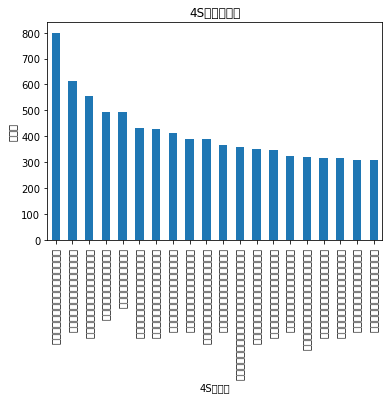

In [8]:
cusfre20.plot(kind='bar')
plt.title(u"4S店订单数目") # puts a title on our graph
plt.ylabel(u"订单数")
plt.xlabel(u"4S店名称")
# plt.savefig("4S店订单数目.pdf",dpi = 150)#这个方法要在plt，show之前调用
plt.show()

In [9]:
#得到的这段数据是没有办法做分析的，先尝试对订单整理做一点分析
order=anjiDF[['PICK_DEVROW','PICK_SDNO','PICK_SDROW','PICK_CUSTOMER','PICK_QTY']]
order.head(3)#选取有变化的数字类型数据集中到一起，对于没有变化的object类型尽量舍弃

,PICK_DEVROW,PICK_SDNO,PICK_SDROW,PICK_CUSTOMER,PICK_QTY
0,20,3871787.0,4400.0,12013.0,1.0
1,210,3897219.0,1300.0,12766.0,10.0
2,310,3897219.0,2400.0,12766.0,1.0


In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
#先把需要的包导入

In [11]:
#定义一个寻找最适合聚类个数的函数，这一步的运算量比较大，在实际部署的时候只能根据抽样测试的各个结果去综合尝试
def find_k (X, k_range, sample_percent=1):
    """
    k_range: a list of possible k values
    X, the data we're clustering on
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    N = X.shape[0]
    sampleSize = X.shape[0] * sample_percent

    if sampleSize > 0:
        index = np.arange(np.shape(X)[0])
        np.random.shuffle(index)
        X =  X[index, :]


    mean_distortions=[]
    for k in k_range:
        #cluster using k, then calculate the mean distortion (average distance to closest centroid)
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(X)
        mean_distortions.append(sum(np.min(pairwise_distances(X, kmeans_model.cluster_centers_,
                                                              metric='euclidean'),axis=1)) / X.shape[0])


    #visualize results
    plt.plot(k_range, mean_distortions)
    plt.xlabel(u"标签个数")
    plt.ylabel(u"聚类紧凑度")
    plt.title(u"标签个数与聚类紧凑度关系")
#     plt.savefig("mean_distortions.png",dpi=200)
    plt.show()

In [12]:
#去掉含有空值的行
orderHavenoNa=order.dropna()

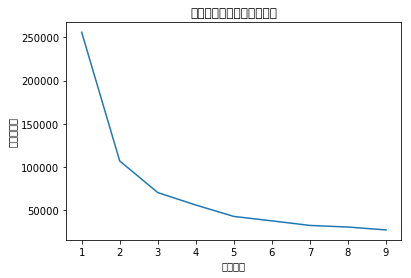

In [13]:
#调用寻找K值的函数
find_k(np.matrix(orderHavenoNa), range(1,10),1)

In [14]:
#为了让数据更有区分度，让数据的类聚集的更加紧密，结合上图，选择7是最划算的，因此从7开始，依次尝试8,9,10,11
kmeans_model7 = KMeans(n_clusters=7, random_state=42)
kmeans_model7.fit(orderHavenoNa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [15]:
orderHavenoNa['labels7']= kmeans_model7.labels_
orderHavenoNa.head(3)

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,PICK_DEVROW,PICK_SDNO,PICK_SDROW,PICK_CUSTOMER,PICK_QTY,labels7
0,20,3871787.0,4400.0,12013.0,1.0,0
1,210,3897219.0,1300.0,12766.0,10.0,0
2,310,3897219.0,2400.0,12766.0,1.0,0


In [16]:
#如果将PICK_CUSTOMER这个表示客户编号的信息去掉再去聚类，会产生怎么样的结果呢
kmeans_model7other = KMeans(n_clusters=7, random_state=42)
kmeans_model7other.fit(orderHavenoNa[['PICK_DEVROW','PICK_SDNO','PICK_SDROW','PICK_QTY']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [17]:
orderHavenoNa['labels7other']= kmeans_model7other.labels_

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
#8个标签划分
kmeans_model8 = KMeans(n_clusters=8, random_state=42)
kmeans_model8.fit(orderHavenoNa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [19]:
orderHavenoNa['labels8']= kmeans_model8.labels_

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
#如果将PICK_CUSTOMER这个表示客户编号的信息去掉,8个标签聚类
kmeans_model8other = KMeans(n_clusters=8, random_state=42)
kmeans_model8other.fit(orderHavenoNa[['PICK_DEVROW','PICK_SDNO','PICK_SDROW','PICK_QTY']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [21]:
orderHavenoNa['labels8other']= kmeans_model8other.labels_

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
#8个标签划分
kmeans_model9 = KMeans(n_clusters=9, random_state=42)
kmeans_model9.fit(orderHavenoNa)
orderHavenoNa['labels9']= kmeans_model9.labels_

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
#如果将PICK_CUSTOMER这个表示客户编号的信息去掉,8个标签聚类
kmeans_model9other = KMeans(n_clusters=9, random_state=42)
kmeans_model9other.fit(orderHavenoNa[['PICK_DEVROW','PICK_SDNO','PICK_SDROW','PICK_QTY']])
orderHavenoNa['labels9other']= kmeans_model9other.labels_

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


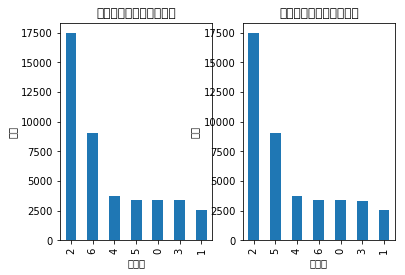

In [24]:
#到此为止，我们把标签从7到9，带客户号和不带客户号的聚类都做了一遍，下面逐步比较这个结果
#查看生成的文件发现这样做之后还是存在差别的，我们可以尝试画图比较一下二者的区别
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
plt.subplot2grid((1,2),(0,0))   
orderHavenoNa['labels7'].value_counts().plot(kind='bar')
plt.title(u"第一种方式标签分布情况") # puts a title on our graph
plt.ylabel(u"个数") 
plt.xlabel(u"标签号")
plt.subplot2grid((1,2),(0,1))   
orderHavenoNa['labels7other'].value_counts().plot(kind='bar')
plt.title(u"第二种方式标签分布情况") # puts a title on our graph
plt.ylabel(u"个数") 
plt.xlabel(u"标签号")
#plt.savefig("两种标签分布情况.png",dpi=200)
plt.show()

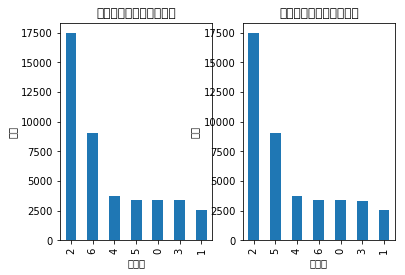

In [25]:
#到此为止，我们把标签从7到9，带客户号和不带客户号的聚类都做了一遍，下面逐步比较这个结果
#查看生成的文件发现这样做之后还是存在差别的，我们可以尝试画图比较一下二者的区别
#ordercluster=pd.read_csv('/home/dongdou/anji-csv/order_cluster.csv')
#orderclusterother=pd.read_csv('/home/dongdou/anji-csv/order_clusterother.csv')
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
plt.subplot2grid((1,2),(0,0))   
orderHavenoNa['labels7'].value_counts().plot(kind='bar')
plt.title(u"第一种方式标签分布情况") # puts a title on our graph
plt.ylabel(u"个数") 
plt.xlabel(u"标签号")
plt.subplot2grid((1,2),(0,1))   
orderHavenoNa['labels7other'].value_counts().plot(kind='bar')
plt.title(u"第二种方式标签分布情况") # puts a title on our graph
plt.ylabel(u"个数") 
plt.xlabel(u"标签号")
#plt.savefig("两种标签分布情况.png",dpi=200)
plt.show()

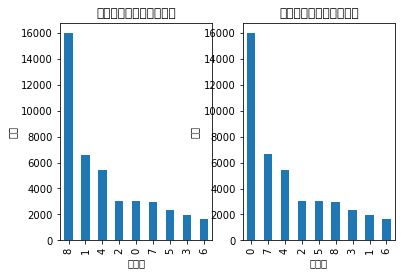

In [26]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
plt.subplot2grid((1,2),(0,0))   
orderHavenoNa['labels9'].value_counts().plot(kind='bar')
plt.title(u"第一种方式标签分布情况") # puts a title on our graph
plt.ylabel(u"个数") 
plt.xlabel(u"标签号")
plt.subplot2grid((1,2),(0,1))   
orderHavenoNa['labels9other'].value_counts().plot(kind='bar')
plt.title(u"第二种方式标签分布情况") # puts a title on our graph
plt.ylabel(u"个数") 
plt.xlabel(u"标签号")
#plt.savefig("两种标签分布情况.png",dpi=200)
plt.show()

In [27]:
filter6=orderHavenoNa[orderHavenoNa['PICK_CUSTOMER']>60000]
filter6.head(3)

,PICK_DEVROW,PICK_SDNO,PICK_SDROW,PICK_CUSTOMER,PICK_QTY,labels7,labels7other,labels8,labels8other,labels9,labels9other
10,30,3897222.0,8300.0,60042.0,1.0,0,0,6,6,5,3
11,10,3875060.0,300.0,60361.0,1.0,0,0,6,6,5,3
14,370,3897683.0,4300.0,60248.0,3.0,0,0,6,6,5,3


In [28]:
filter=orderHavenoNa[orderHavenoNa['PICK_CUSTOMER']<60000]
filter2=filter[filter['PICK_CUSTOMER']>12000]
filter2.head(3)

,PICK_DEVROW,PICK_SDNO,PICK_SDROW,PICK_CUSTOMER,PICK_QTY,labels7,labels7other,labels8,labels8other,labels9,labels9other
0,20,3871787.0,4400.0,12013.0,1.0,0,0,6,6,5,3
1,210,3897219.0,1300.0,12766.0,10.0,0,0,6,6,5,3
2,310,3897219.0,2400.0,12766.0,1.0,0,0,6,6,5,3


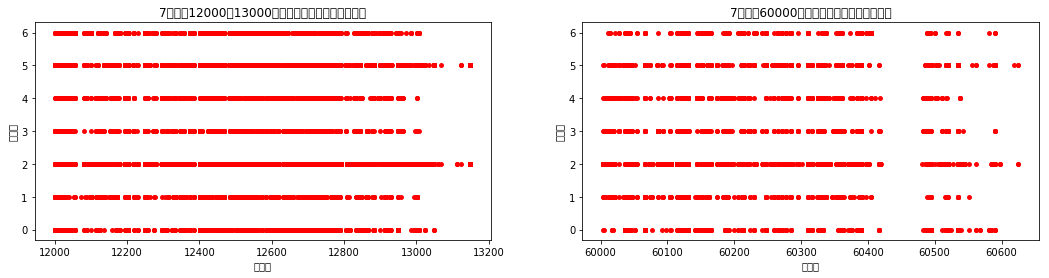

In [29]:
plt.figure(figsize=(18,4));
ax1 = plt.subplot(121)
plt.scatter(filter2['PICK_CUSTOMER'], filter2['labels7other'], marker = 'o', color = 'r', label='3', s = 15)
plt.title(u'7个标签12000与13000之间的客户号与标签对应示意') # puts a title on our graph
plt.ylabel(u'客户号') 
plt.xlabel(u'标签号')
# generate predictions from our fitted model
ax2 = plt.subplot(122)
plt.scatter(filter6['PICK_CUSTOMER'], filter6['labels7other'], marker = 'o', color = 'r', label='3', s = 15)
plt.title(u"7个标签60000以上的客户号与标签对应示意") # puts a title on our graph
plt.ylabel(u"客户号") 
plt.xlabel(u"标签号")
# #plt.savefig("4.png",dpi=200)
# plt.scatter(filter2['PICK_CUSTOMER'], filter2['labels7'], marker = 'o', color = 'r', label='3', s = 15)
# plt.title(u"12000与13000之间的客户号与标签对应示意") # puts a title on our graph
# plt.ylabel(u"客户号") 
# plt.xlabel(u"标签号")
#plt.savefig("3.png",dpi=200)

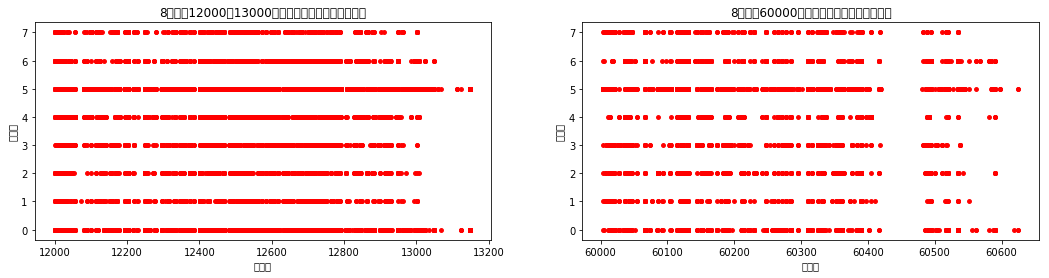

In [30]:
plt.figure(figsize=(18,4));
ax1 = plt.subplot(121)
plt.scatter(filter2['PICK_CUSTOMER'], filter2['labels8other'], marker = 'o', color = 'r', label='3', s = 15)
plt.title(u'8个标签12000与13000之间的客户号与标签对应示意') # puts a title on our graph
plt.ylabel(u'客户号') 
plt.xlabel(u'标签号')
# generate predictions from our fitted model
ax2 = plt.subplot(122)
plt.scatter(filter6['PICK_CUSTOMER'], filter6['labels8other'], marker = 'o', color = 'r', label='3', s = 15)
plt.title(u"8个标签60000以上的客户号与标签对应示意") # puts a title on our graph
plt.ylabel(u"客户号") 
plt.xlabel(u"标签号")
# plt.scatter(filter2['PICK_CUSTOMER'], filter2['labels8other'], marker = 'o', color = 'r', label='3', s = 15)
# plt.title(u"12000与13000之间的客户号与标签对应示意") # puts a title on our graph
# plt.ylabel(u"客户号") 
# plt.xlabel(u"标签号")

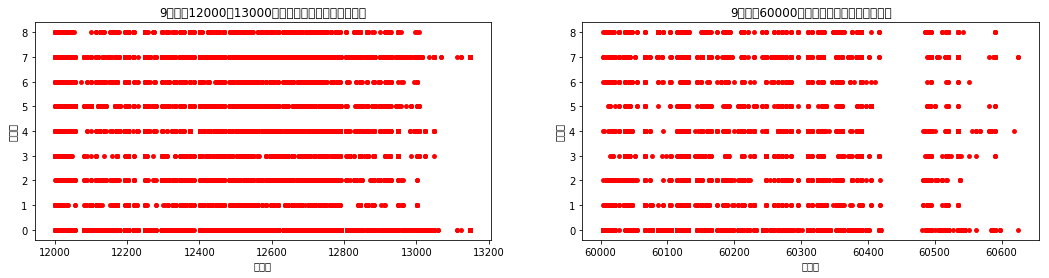

In [31]:
plt.figure(figsize=(18,4));
ax1 = plt.subplot(121)
plt.scatter(filter2['PICK_CUSTOMER'], filter2['labels9other'], marker = 'o', color = 'r', label='3', s = 15)
plt.title(u'9个标签12000与13000之间的客户号与标签对应示意') # puts a title on our graph
plt.ylabel(u'客户号') 
plt.xlabel(u'标签号')
# generate predictions from our fitted model
ax2 = plt.subplot(122)
plt.scatter(filter6['PICK_CUSTOMER'], filter6['labels9other'], marker = 'o', color = 'r', label='3', s = 15)
plt.title(u"9个标签60000以上的客户号与标签对应示意") # puts a title on our graph
plt.ylabel(u"客户号") 
plt.xlabel(u"标签号")
# plt.scatter(filter2['PICK_CUSTOMER'], filter2['labels9other'], marker = 'o', color = 'r', label='3', s = 15)
# plt.title(u"12000与13000之间的客户号与标签对应示意") # puts a title on our graph
# plt.ylabel(u"客户号") 
# plt.xlabel(u"标签号")

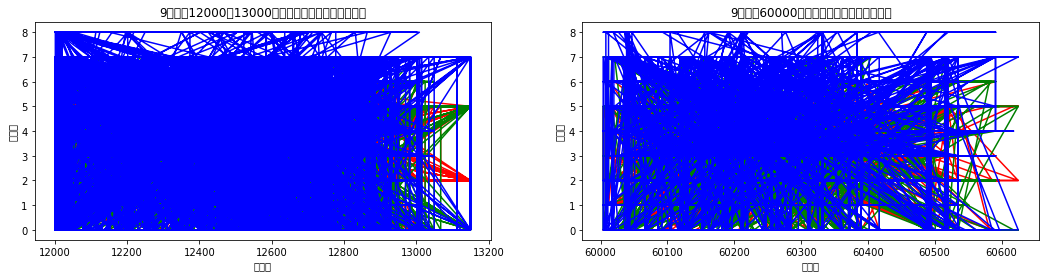

In [32]:
#通过上述分析，可以得到以下结论，1等级划分成7,8,9以上都是合理的，只要计算能力够，但是再多的化性价比不高，所以9这个等级可以作为
#大量数据分析的参照，2聚类分析必须把客户号这个特征给丢弃才能比较客观。
#下面再画一个合成图，看看不同等级之间产生什么样的区别
plt.figure(figsize=(18,4));
ax1 = plt.subplot(121)
plt.plot(filter2['PICK_CUSTOMER'], filter2['labels7other'],color = 'r')
plt.plot(filter2['PICK_CUSTOMER'], filter2['labels8other'],color = 'g')
plt.plot(filter2['PICK_CUSTOMER'], filter2['labels9other'],color = 'b')
plt.title(u'9个标签12000与13000之间的客户号与标签对应示意') # puts a title on our graph
plt.ylabel(u'客户号') 
plt.xlabel(u'标签号')
# generate predictions from our fitted model
ax2 = plt.subplot(122)
plt.plot(filter6['PICK_CUSTOMER'], filter6['labels7other'],color = 'r')
plt.plot(filter6['PICK_CUSTOMER'], filter6['labels8other'],color = 'g')
plt.plot(filter6['PICK_CUSTOMER'], filter6['labels9other'],color = 'b')
plt.title(u"9个标签60000以上的客户号与标签对应示意") # puts a title on our graph
plt.ylabel(u"客户号") 
plt.xlabel(u"标签号")

In [33]:
#从上图发现几种不同的划分重合部分不是很多，不如把结果保存成文件，手动看看结果
orderHavenoNa.to_csv('/root/orderclustersum.csv')

In [34]:
#use pca to decomsion the source data
from sklearn.decomposition import PCA
data=orderHavenoNa[['PICK_DEVROW','PICK_SDNO','PICK_SDROW','PICK_QTY']]
reduced_data = PCA(n_components=2).fit_transform(data)#PCA降维

In [35]:
reduced_data.shape

(42969, 2)

In [36]:
#ok decomposition is finished 
kmeans_model_pca7 = KMeans(n_clusters=7, random_state=42)
kmeans_model_pca7.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [37]:
orderHavenoNa['labels7pca']= kmeans_model_pca7.labels_

/root/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
y_pred=KMeans(n_clusters=7, random_state=42).fit_predict(reduced_data)

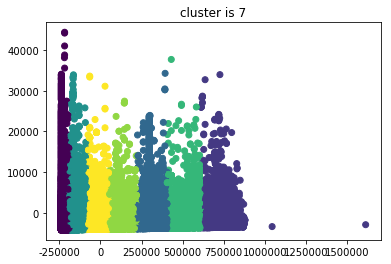

In [39]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred)
plt.title("cluster is 7")
plt.show()

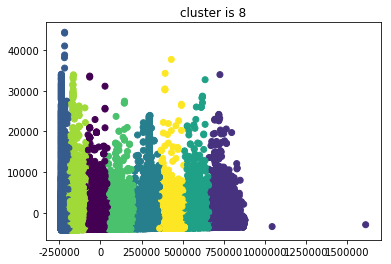

In [40]:
y_pred=KMeans(n_clusters=8, random_state=42).fit_predict(reduced_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred)
plt.title("cluster is 8")
plt.show()

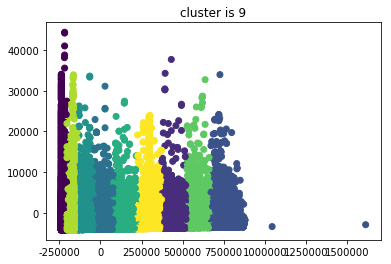

In [41]:
y_pred=KMeans(n_clusters=9, random_state=42).fit_predict(reduced_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_pred)
plt.title("cluster is 9")
plt.show()